# 📌 ML-based IV Spread Trading Strategy

This notebook builds and backtests a simple **machine learning–driven trading strategy** using IV spread data (`banknifty - nifty`) and time-to-expiry (`tte`).

---

### 🔹 Workflow

1. **Data Preparation**
   - Load cleaned Parquet file with time-indexed spread data.  
   - Compute theoretical P/L:  `theo_pl' = `spread' * `tte'^0.7
   - Create lag features (`spread_lag1`, `spread_lag2`, `tte_lag1`) for prediction.  

2. **Model Training**
   - Use **Gradient Boosting Regressor** to predict future `theo_pl`.  
   - Train/test split (80/20), scale features, and fit the model.  

3. **Signal Generation**
   - If predicted P/L (`pred_pl`) > 0 → **go long spread** (+1).  
   - Else → **go short spread** (–1).  
   - Strategy P/L = signal × actual `theo_pl`.  

4. **Backtest & Evaluation**
   - Run on test set, compute:  
     - ✅ Mean Squared Error (MSE)  
     - ✅ Sharpe Ratio  
     - ✅ Max Drawdown  
     - ✅ Final Cumulative PnL  
   - Plot cumulative PnL curve for visualization.  

---

⚡ **In short:**  
We use past spreads and time-to-expiry to **train an ML model that predicts future P/L**, trade based on those predictions, and evaluate the strategy with performance metrics and a PnL plot.


Test MSE: 0.0020
Sharpe Ratio: 66.32
Max Drawdown: -0.17
Final Cumulative PnL: 38593.15


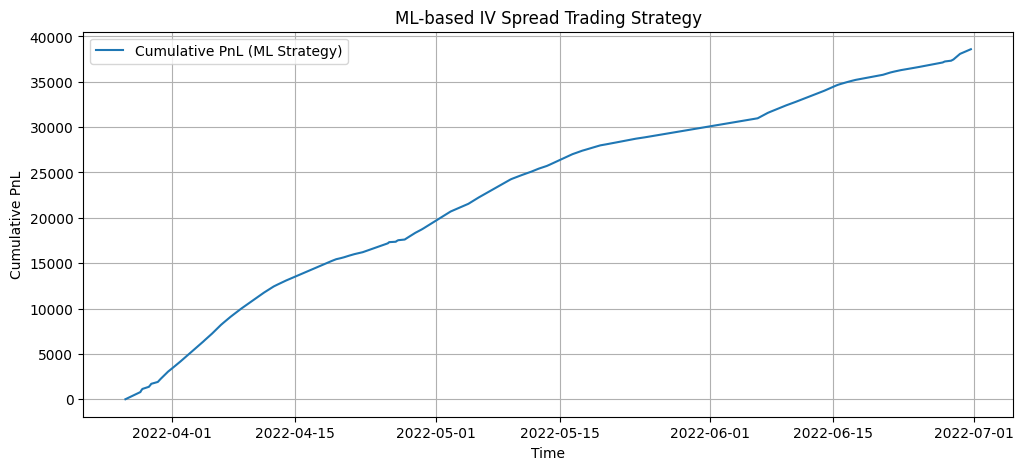

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# === Load Data ===
df = pd.read_parquet("data_cleaned.parquet")
df = df.set_index("time") if "time" in df.columns else df
df = df.dropna()

# === Features & Targets ===
df["spread"] = df["banknifty"] - df["nifty"]
df["theo_pl"] = df["spread"] * (df["tte"] ** 0.7)

# Lag features for prediction
df["spread_lag1"] = df["spread"].shift(1)
df["spread_lag2"] = df["spread"].shift(2)
df["tte_lag1"] = df["tte"].shift(1)
df = df.dropna()

X = df[["spread_lag1", "spread_lag2", "tte_lag1"]]
y = df["theo_pl"]

# === Train/Test Split ===
split = int(0.8 * len(df))
X_train, X_test, y_train, y_test = X.iloc[:split], X.iloc[split:], y.iloc[:split], y.iloc[split:]

# === Scale features ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === ML Model ===
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=4)
model.fit(X_train, y_train)

# === Predictions ===
df["pred_pl"] = model.predict(scaler.transform(X))
df["signal"] = np.where(df["pred_pl"] > 0, 1, -1)   # long spread if predicted P/L positive
df["strategy_pl"] = df["signal"] * df["theo_pl"]

# === Backtest on Test Set ===
test_df = df.iloc[split:].copy()
cum_pnl = test_df["strategy_pl"].cumsum()
sharpe = (test_df["strategy_pl"].mean() / test_df["strategy_pl"].std()) * np.sqrt(252*6.25)  # 6.25 hrs per day
roll_max = cum_pnl.cummax()
drawdown = (cum_pnl - roll_max).min()

print(f"Test MSE: {mean_squared_error(y_test, test_df['pred_pl']):.4f}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {drawdown:.2f}")
print(f"Final Cumulative PnL: {cum_pnl.iloc[-1]:.2f}")

# === Plot ===
plt.figure(figsize=(12,5))
plt.plot(cum_pnl, label="Cumulative PnL (ML Strategy)")
plt.title("ML-based IV Spread Trading Strategy")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.grid(True)
plt.show()

### Here I have taken a 1 minute latency for execution

Test MSE: 0.0020
Sharpe Ratio: 66.32
Max Drawdown: -0.17
Final Cumulative PnL: 38592.87


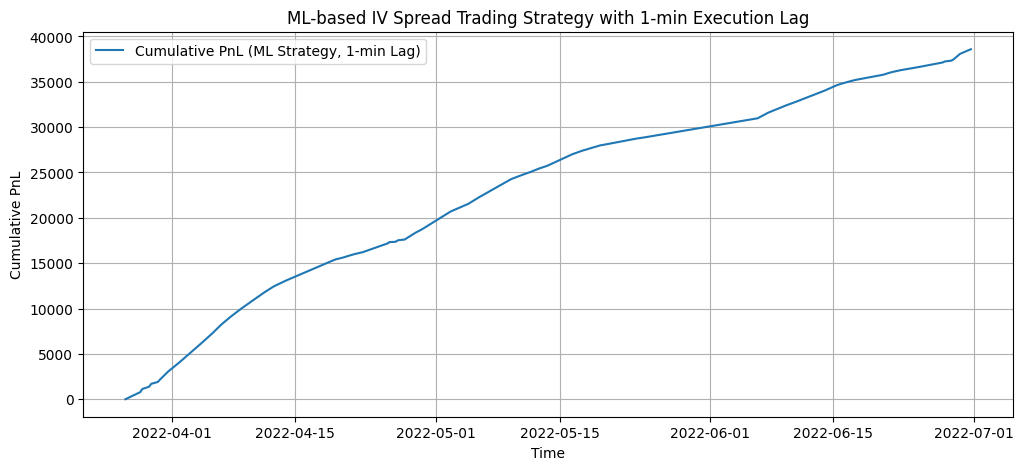

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# === Load Data ===
df = pd.read_parquet("data_cleaned.parquet")
df = df.set_index("time") if "time" in df.columns else df
df = df.dropna()

# === Features & Targets ===
df["spread"] = df["banknifty"] - df["nifty"]
df["theo_pl"] = df["spread"] * (df["tte"] ** 0.7)

# Lag features for prediction
df["spread_lag1"] = df["spread"].shift(1)
df["spread_lag2"] = df["spread"].shift(2)
df["tte_lag1"]    = df["tte"].shift(1)
df = df.dropna()

# === Features/Target ===
X = df[["spread_lag1", "spread_lag2", "tte_lag1"]]
y = df["theo_pl"]

# === Train/Test Split ===
split = int(0.8 * len(df))
X_train, X_test, y_train, y_test = X.iloc[:split], X.iloc[split:], y.iloc[:split], y.iloc[split:]

# === Scale features ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === ML Model ===
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=4)
model.fit(X_train, y_train)

# === Predictions ===
df["pred_pl"] = model.predict(scaler.transform(X))
df["signal"] = np.where(df["pred_pl"] > 0, 1, -1)   # signal generated at time t

# Shift signal by 1 minute to simulate execution delay
df["signal"] = df["signal"].shift(1)

# Drop NaN caused by the shift
df = df.dropna()

# Recreate X, y, split after alignment
X = df[["spread_lag1", "spread_lag2", "tte_lag1"]]
y = df["theo_pl"]
split = int(0.8 * len(df))
y_test = y.iloc[split:]   # aligned target

# Strategy P&L
df["strategy_pl"] = df["signal"] * df["theo_pl"]

# === Backtest on Test Set ===
test_df = df.iloc[split:].copy()
cum_pnl = test_df["strategy_pl"].cumsum()
sharpe = (test_df["strategy_pl"].mean() / test_df["strategy_pl"].std()) * np.sqrt(252*6.25)  # 6.25 hrs per day
roll_max = cum_pnl.cummax()
drawdown = (cum_pnl - roll_max).min()

print(f"Test MSE: {mean_squared_error(y_test, test_df['pred_pl']):.4f}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {drawdown:.2f}")
print(f"Final Cumulative PnL: {cum_pnl.iloc[-1]:.2f}")

# === Plot ===
plt.figure(figsize=(12,5))
plt.plot(cum_pnl, label="Cumulative PnL (ML Strategy, 1-min Lag)")
plt.title("ML-based IV Spread Trading Strategy with 1-min Execution Lag")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.legend()
plt.grid(True)
plt.show()